Installing missing library

In [1]:
!pip install git+https://github.com/Lasagne/Lasagne

  Cloning https://github.com/Lasagne/Lasagne to /tmp/pip-req-build-tvg9ws48
  Running command git clone -q https://github.com/Lasagne/Lasagne /tmp/pip-req-build-tvg9ws48
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-cp36-none-any.whl size=122797 sha256=6a1ca2a880948c20a2a0ed49a321dec042c3001ce353de7cddbdd1981e6ab1e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ka248z8g/wheels/c4/20/90/9f7242c381402829c5918261e3eb51a87bc1d8521456749b57
Successfully built Lasagne


Importing required standard libraries

In [2]:
import numpy as np #supports mathematical array operations
import os #file management
import gzip #archived file operations
import matplotlib.pyplot as plt #plotting capabilitites
from urllib.request import urlretrieve #downloading from url

Defining a download function which will store the dataset on the local drive and load them into the respective variables

In [3]:
#Defining a download function which will store the dataset on the local drive
def load():
    def download(fn, source='http://yann.lecun.com/exdb/mnist/'):
        print ("Downloading ",fn)
        urlretrieve(source+fn,fn)

#function to download missing images
    def load_images(fn):
        if not os.path.exists(fn): #checking whether the file is missing
            download(fn)         
        with gzip.open(fn,'rb') as f: #extracting compressed file  
            data=np.frombuffer(f.read(), np.uint8, offset=16)
            data=data.reshape(-1,1,28,28) #reshaping the elements into a single array of 28x28 pixels
            return data/np.float32(256) #converting them into float

#function to download missing labels      
    def load_labels(fn):
        if not os.path.exists(fn):
            download(fn)
        with gzip.open(fn,'rb') as f:
            data = np.frombuffer(f.read(),np.uint8,offset=8)
        return data

#calling the sub-function with the filenames and loading the data into respective variables    
    X_train = load_images('train-images-idx3-ubyte.gz')
    y_train = load_labels('train-labels-idx1-ubyte.gz')
    X_test = load_images('t10k-images-idx3-ubyte.gz')
    y_test = load_labels('t10k-labels-idx1-ubyte.gz')
    
    return X_train, y_train, X_test, y_test


Initialising the download function

In [4]:
X_train, y_train, X_test, y_test = load()

Pre-viewing sample data

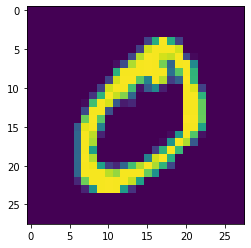

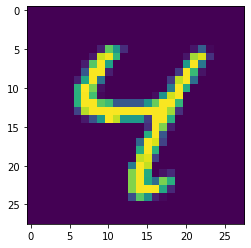

label training:0
label test:4


In [5]:
plt.show(plt.imshow(X_train[1][0])) #1st training image
plt.show(plt.imshow(X_test[6][0]))  #6th testing image
print('label training:'+str(y_train[1])) #1st training label
print('label test:'+str(y_test[6]))      #6th testing label


Setting up a neural network

In [6]:
import lasagne #facilitates network building

import theano 
import theano.tensor as T #supports higher dimensional array operations(Tensors)

Defining a neural network

In [8]:
def NN(in_var=None):
    l_input = lasagne.layers.InputLayer(shape=(None,1,28,28),input_var=in_var) #input layer with the predefined shapes and input variable
    l_input_drop = lasagne.layers.DropoutLayer(l_input,p=0.2) #dropping out 20% of outer edges from input layer
    l_hidden1= lasagne.layers.DenseLayer(l_input_drop,num_units=800,
                                      nonlinearity=lasagne.nonlinearities.rectify,
                                      W=lasagne.init.GlorotUniform()) #first hidden layer with 800 nodes using Glorot's Scheme
    l_hidden1_drop = lasagne.layers.DropoutLayer(l_hidden1,p=0.5) 
    l_hidden2= lasagne.layers.DenseLayer(l_hidden1_drop,num_units=800,
                                      nonlinearity=lasagne.nonlinearities.rectify,
                                      W=lasagne.init.GlorotUniform()) #second hidden layer similar to the first
    l_hidden2_drop = lasagne.layers.DropoutLayer(l_hidden2,p=0.5) #Drop out layer of 50%
    l_output = lasagne.layers.DenseLayer(l_hidden2_drop, num_units=10,
                                     nonlinearity = lasagne.nonlinearities.softmax) #output layer with 10 units of range [0-1] with the max of them being the predicted value
    return l_output #returning the last layer thus effectively calling the entire neural network as they are linked

Defining placeholder arrays for training/test data

In [13]:
in_var = T.tensor4('inputs') # An empty 4 dimensional array 
tar_var = T.ivector('targets') # An empty 1-D integer array to representing the labels 

Calling the function that initializes the neural network 

In [14]:
network=NN(in_var) 

Training function

In [15]:
pred = lasagne.layers.get_output(network) #error function
loss = lasagne.objectives.categorical_crossentropy(pred, tar_var) #calculating loss value using categorical crossentropy
loss = loss.mean() #taking its mean
params = lasagne.layers.get_all_params(network, trainable=True) # Current value of all the weights 
upd = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum = 0.9) #evaluating update values using nesterov momentum
tr_fn = theano.function([in_var, tar_var], loss, updates=upd) #theano function to define training by updating weights

Feeding training data to the network

In [26]:
steps = 5 # 100 steps ideally

for step in range(steps):
    tr_err = tr_fn(X_train, y_train)
    print("Current step is "+ str(step))

Current step is 0
Current step is 1
Current step is 2
Current step is 3
Current step is 4


Checking output for a single image and its label to check whether the model works

In [28]:
tst_pred = lasagne.layers.get_output(network)
val_fn = theano.function([in_var],tst_pred)

val_fn([X_test[10]]) #testing the 10th image

array([[0.43921195, 0.00762011, 0.14994476, 0.13336409, 0.02460235,
        0.11941577, 0.03187808, 0.00290689, 0.08646837, 0.00458763]])

In [21]:
y_test[10] #checking the 10 label

0

Feeding entire data to the network and calculating it's accuracy

In [29]:
tst_pred = lasagne.layers.get_output(network,deterministic=True) #not cutting off edges for consitency in results
test_acc = T.mean(T.eq(T.argmax(tst_pred, axis=1),tar_var),dtype=theano.config.floatX) #checking index of max value and compares it with actual label

acc_fn = theano.function([in_var,tar_var],test_acc)

acc_fn(X_test,y_test)

array(0.8188)